# 10-8. 프로젝트: 인물 모드 문제점 찾기

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#10-8.-프로젝트:-인물-모드-문제점-찾기" data-toc-modified-id="10-8.-프로젝트:-인물-모드-문제점-찾기-1">10-8. 프로젝트: 인물 모드 문제점 찾기</a></span><ul class="toc-item"><li><span><a href="#Step-1.-인물모드-직접-해-보기" data-toc-modified-id="Step-1.-인물모드-직접-해-보기-1.1">Step 1. 인물모드 직접 해 보기</a></span><ul class="toc-item"><li><span><a href="#A.-여진구" data-toc-modified-id="A.-여진구-1.1.1">A. 여진구</a></span><ul class="toc-item"><li><span><a href="#사용할-패키지를-불러옵니다." data-toc-modified-id="사용할-패키지를-불러옵니다.-1.1.1.1">사용할 패키지를 불러옵니다.</a></span></li><li><span><a href="#이미지를-읽습니다." data-toc-modified-id="이미지를-읽습니다.-1.1.1.2">이미지를 읽습니다.</a></span></li><li><span><a href="#DeepLab-모델을-준비합니다." data-toc-modified-id="DeepLab-모델을-준비합니다.-1.1.1.3">DeepLab 모델을 준비합니다.</a></span></li><li><span><a href="#사전에-학습된-가중치를-불러옵니다." data-toc-modified-id="사전에-학습된-가중치를-불러옵니다.-1.1.1.4">사전에 학습된 가중치를 불러옵니다.</a></span></li><li><span><a href="#준비된-이미지를-네트워크에-입력합니다." data-toc-modified-id="준비된-이미지를-네트워크에-입력합니다.-1.1.1.5">준비된 이미지를 네트워크에 입력합니다.</a></span></li><li><span><a href="#마스크를-만들고-시각화" data-toc-modified-id="마스크를-만들고-시각화-1.1.1.6">마스크를 만들고 시각화</a></span></li><li><span><a href="#세그멘테이션-결과(mask)를-원래-크기로-복원" data-toc-modified-id="세그멘테이션-결과(mask)를-원래-크기로-복원-1.1.1.7">세그멘테이션 결과(mask)를 원래 크기로 복원</a></span></li><li><span><a href="#세그멘테이션-마스크를-이용해서-배경만-추출하기" data-toc-modified-id="세그멘테이션-마스크를-이용해서-배경만-추출하기-1.1.1.8">세그멘테이션 마스크를 이용해서 배경만 추출하기</a></span></li><li><span><a href="#배경이미지-흐리게-만들기" data-toc-modified-id="배경이미지-흐리게-만들기-1.1.1.9">배경이미지 흐리게 만들기</a></span></li><li><span><a href="#배경-이미지와-사람-이미지-합치기" data-toc-modified-id="배경-이미지와-사람-이미지-합치기-1.1.1.10">배경 이미지와 사람 이미지 합치기</a></span></li></ul></li><li><span><a href="#B.-고양이" data-toc-modified-id="B.-고양이-1.1.2">B. 고양이</a></span></li><li><span><a href="#C.-배경전환-크로마키사진" data-toc-modified-id="C.-배경전환-크로마키사진-1.1.3">C. 배경전환 크로마키사진</a></span></li></ul></li><li><span><a href="#Step-2.-사진에서-문제점-찾기" data-toc-modified-id="Step-2.-사진에서-문제점-찾기-1.2">Step 2. 사진에서 문제점 찾기</a></span></li><li><span><a href="#Step-3.-해결-방법을-제안해-보기" data-toc-modified-id="Step-3.-해결-방법을-제안해-보기-1.3">Step 3. 해결 방법을 제안해 보기</a></span></li><li><span><a href="#후기" data-toc-modified-id="후기-1.4">후기</a></span></li></ul></li></ul></div>

## Step 1. 인물모드 직접 해 보기

### A. 여진구

#### 사용할 패키지를 불러옵니다.

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib  # 웹에서 데이터를 다운로드 받을 때 사용합니다.

from matplotlib import pyplot as plt
import tensorflow as tf

#### 이미지를 읽습니다.

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/1.jpg'
img_orig = cv2.imread(img_path)

print(img_orig.shape)

(446, 670, 3)


#### DeepLab 모델을 준비합니다.

구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만듭니다.

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다.
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(
                    file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        """input tensor를 만들기 위해 이미지를 전처리합니다."""
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input

    def run(self, image):
        """실제로 세그멘테이션을 하는 함수"""
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

#### 사전에 학습된 가중치를 불러옵니다.

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                               download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj61/aiffel/human_segmentation/models
model loaded successfully!


#### 준비된 이미지를 네트워크에 입력합니다.

In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(446, 670, 3) (341, 513, 3) 15


#### 마스크를 만들고 시각화

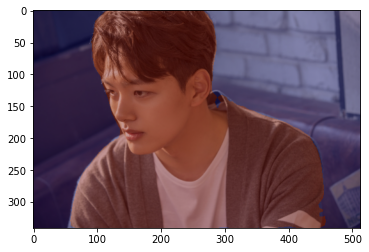

In [6]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)  # 예측 중 사람만 추출
img_mask = seg_map*(255/seg_map.max())  # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### 세그멘테이션 결과(mask)를 원래 크기로 복원

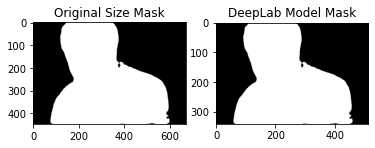

In [7]:
img_mask_up = cv2.resize(
    img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#### 세그멘테이션 마스크를 이용해서 배경만 추출하기

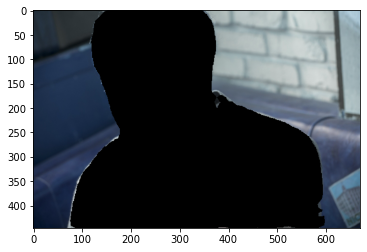

In [8]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

#### 배경이미지 흐리게 만들기

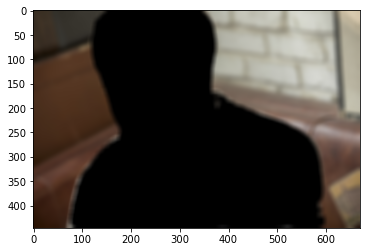

In [9]:
img_bg_blur = cv2.blur(img_bg, (13, 13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 배경 이미지와 사람 이미지 합치기

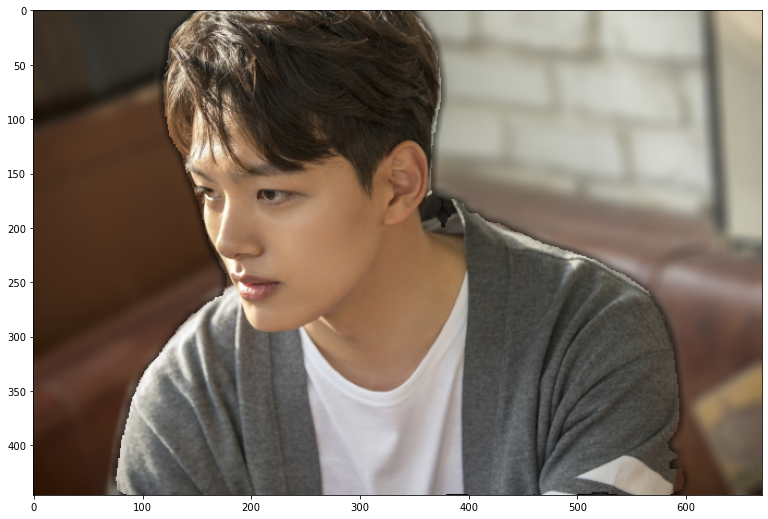

In [10]:
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)
plt.figure(figsize=(13.4, 8.92))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### B. 고양이

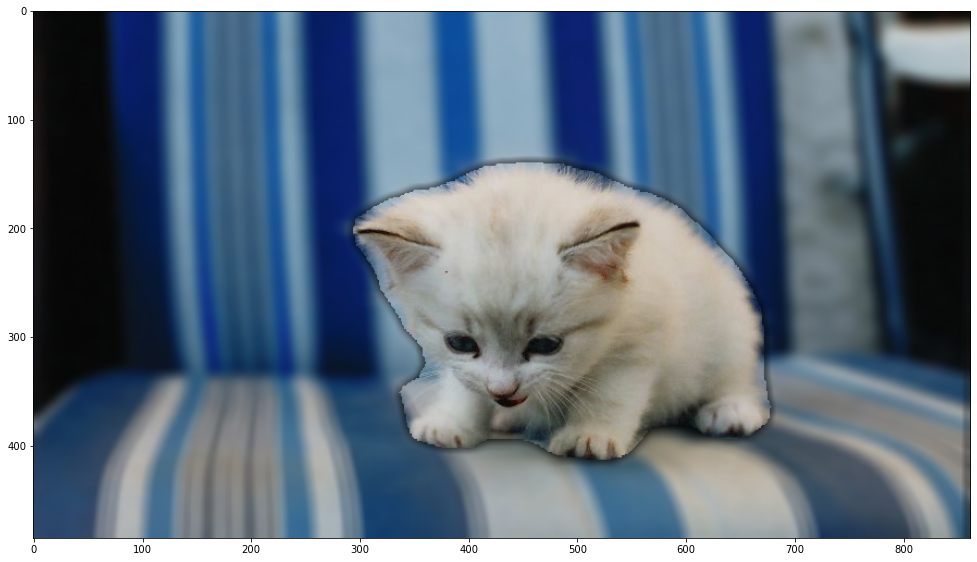

In [11]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/2.jpg'
img_orig = cv2.imread(img_path)

# 이미지를 네트워크에 입력
img_resized, seg_map = MODEL.run(img_orig)

# 마스크 만들고 시각화
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0)  # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max())  # 255 normalization
img_mask = img_mask.astype(np.uint8)

# 원래 크기로 복원
img_mask_up = cv2.resize(
    img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# 배경 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

# 배경 흐리게
img_bg_blur = cv2.blur(img_bg, (13, 13))

# 합치기
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)

# 보여주기
plt.figure(figsize=(17.24, 9.70))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### C. 배경전환 크로마키사진

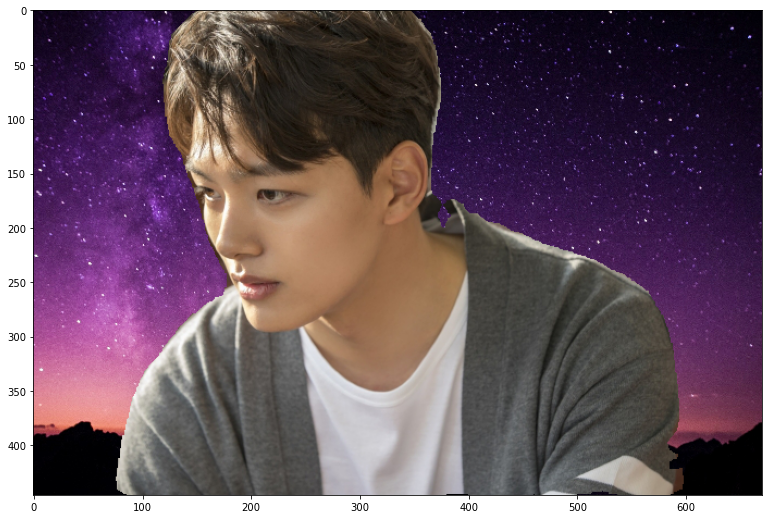

In [12]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/1.jpg'
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/3.jpg'
img_orig = cv2.imread(img_path)
bg_orig = cv2.imread(bg_path)

# 이미지를 네트워크에 입력
img_resized, seg_map = MODEL.run(img_orig)

# 마스크 만들고 시각화
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)  # 사람
img_mask = seg_map * (255/seg_map.max())  # 255 normalization
img_mask = img_mask.astype(np.uint8)

# 원래 크기로 복원
img_mask_up = cv2.resize(
    img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# 새로운 배경 리사이즈
img_bg = cv2.resize(bg_orig, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)

# 배경 추출 후 교체
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_bg, img_bg_mask)

# 합치기
img_concat = np.where(img_mask_color == 255, img_orig, img_bg)

# 보여주기
plt.figure(figsize=(13.4, 8.92))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## Step 2. 사진에서 문제점 찾기

마스킹된 이미지와 블러처리한 이미지의 간극이 커서 마치 두꺼운 외곽선이 생긴 것처럼 보이고 자연스럽지 못합니다.

## Step 3. 해결 방법을 제안해 보기

- 참고 : [https://github.com/kairess/Mask_RCNN](https://github.com/kairess/Mask_RCNN)
- 아래 이미지를 클릭하면 해당 영상을 볼 수 있습니다.
[![](https://img.youtube.com/vi/NRB7Mp41f64/maxresdefault.jpg)](https://youtu.be/NRB7Mp41f64)

사람과 배경을 분리해 배경에만 블러처리를 할 경우에는 이미지가 어색합니다.  
그래서 마스킹한 이미지에도 블러처리를 해 경계면이 자연스럽도록 만들어줍니다.

1. 사람을 마스킹한 이미지를 블러처리한 후 원본이미지와 곱합니다.  
2. 나머지 배경 부분은 원본이미지를 블러처리한 이미지와 곱합니다.  
3. 두 이미지를 합치면 자연스러운 결과물이 완성됩니다.

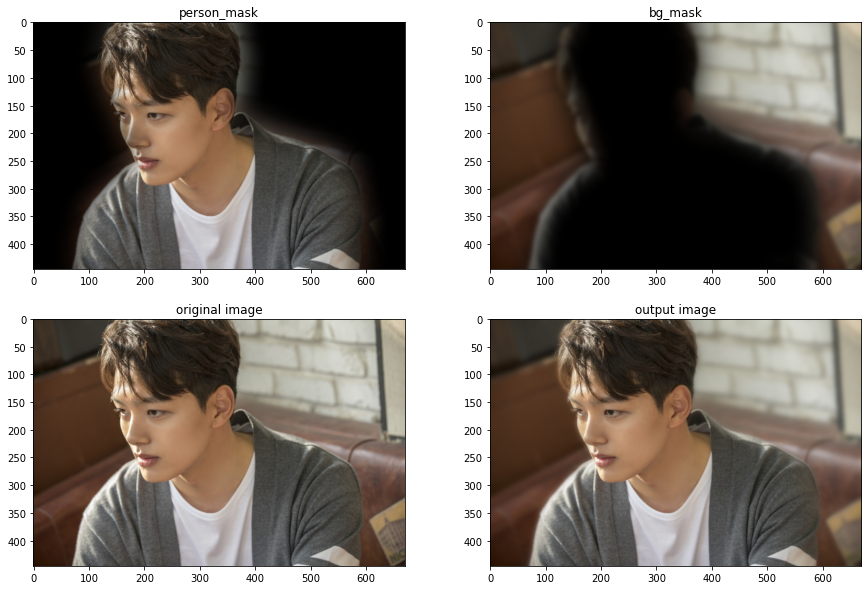

In [13]:
# load image
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/1.jpg'
img_orig = cv2.imread(img_path)

# run detection
img_resized, seg_map = MODEL.run(img_orig)

# mask
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)  # 사람
img_mask = seg_map*(255/seg_map.max())    # 255 normalization
img_mask = img_mask.astype(np.uint8)

# restore to original size
img_mask_up = cv2.resize(
    img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# 원본 이미지와 연산하기 위해 3차원으로 변환해줍니다.
mask_3d = np.repeat(np.expand_dims(img_mask_up, axis=2),
                    3, axis=2).astype(np.uint8)

# blur original image
blurred_img = cv2.GaussianBlur(img_orig, (25, 25), 0)

# blur mask image
mask_3d_blurred = (cv2.GaussianBlur(
    mask_3d, (101, 101), 25, 25)/255).astype(np.float32)

# mix it together
person_mask = mask_3d_blurred*img_orig.astype(np.float32)
bg_mask = (1-mask_3d_blurred)*blurred_img.astype(np.float32)
out = (person_mask+bg_mask).astype(np.uint8)

# visualize
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.title('person_mask')
plt.imshow(cv2.cvtColor(person_mask.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.subplot(2, 2, 2)
plt.title('bg_mask')
plt.imshow(cv2.cvtColor(bg_mask.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.subplot(2, 2, 3)
plt.title('original image')
plt.imshow(cv2.cvtColor(img_orig.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.subplot(2, 2, 4)
plt.title('output image')
plt.imshow(cv2.cvtColor(out.astype(np.uint8), cv2.COLOR_BGR2RGB))

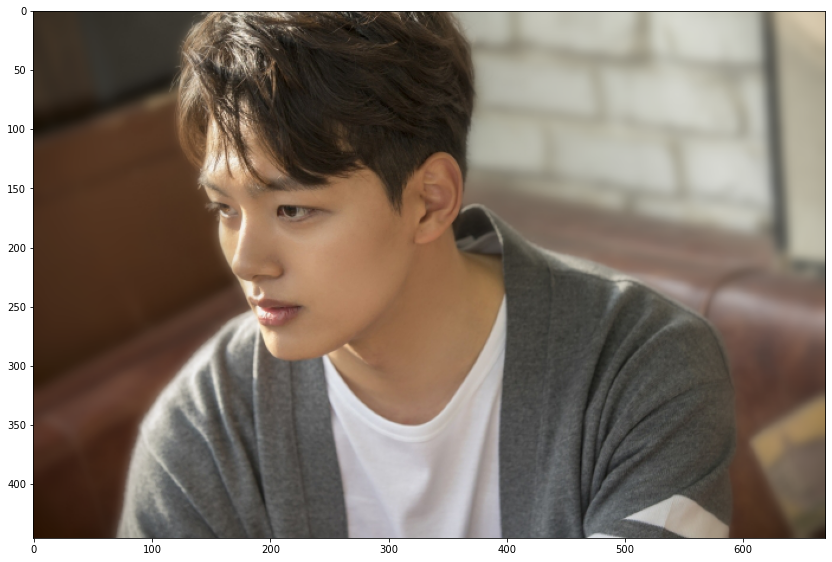

In [14]:
# visualize
plt.figure(figsize=(17.24, 9.70))
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plt.show()

존잘

고양이도 그려봅니다.

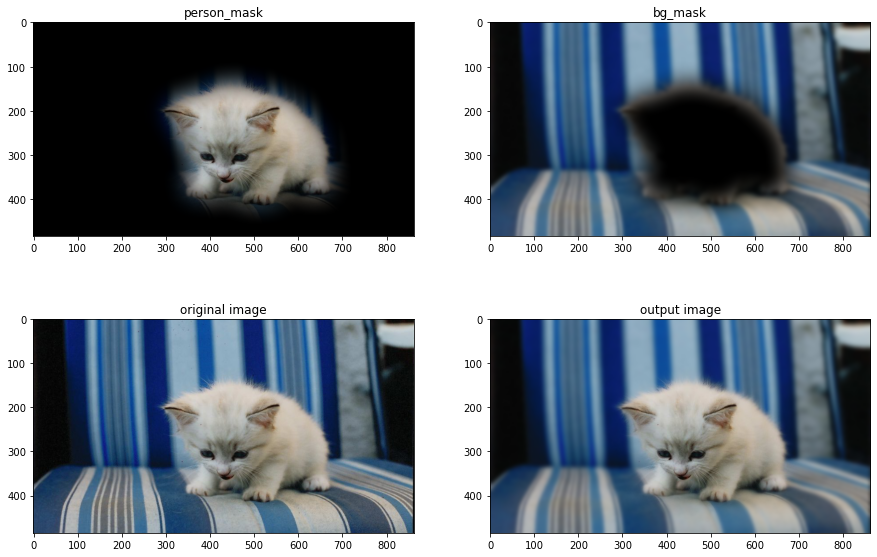

In [15]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/2.jpg'
img_orig = cv2.imread(img_path)
img_resized, seg_map = MODEL.run(img_orig)
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0)
img_mask = seg_map*(255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
img_mask_up = cv2.resize(
    img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
mask_3d = np.repeat(np.expand_dims(img_mask_up, axis=2),
                    3, axis=2).astype(np.uint8)
blurred_img = cv2.GaussianBlur(img_orig, (25, 25), 0)
mask_3d_blurred = (cv2.GaussianBlur(
    mask_3d, (101, 101), 25, 25)/255).astype(np.float32)
person_mask = mask_3d_blurred*img_orig.astype(np.float32)
bg_mask = (1-mask_3d_blurred)*blurred_img.astype(np.float32)
out = (person_mask+bg_mask).astype(np.uint8)
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.title('person_mask')
plt.imshow(cv2.cvtColor(person_mask.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.subplot(2, 2, 2)
plt.title('bg_mask')
plt.imshow(cv2.cvtColor(bg_mask.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.subplot(2, 2, 3)
plt.title('original image')
plt.imshow(cv2.cvtColor(img_orig.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.subplot(2, 2, 4)
plt.title('output image')
plt.imshow(cv2.cvtColor(out.astype(np.uint8), cv2.COLOR_BGR2RGB))

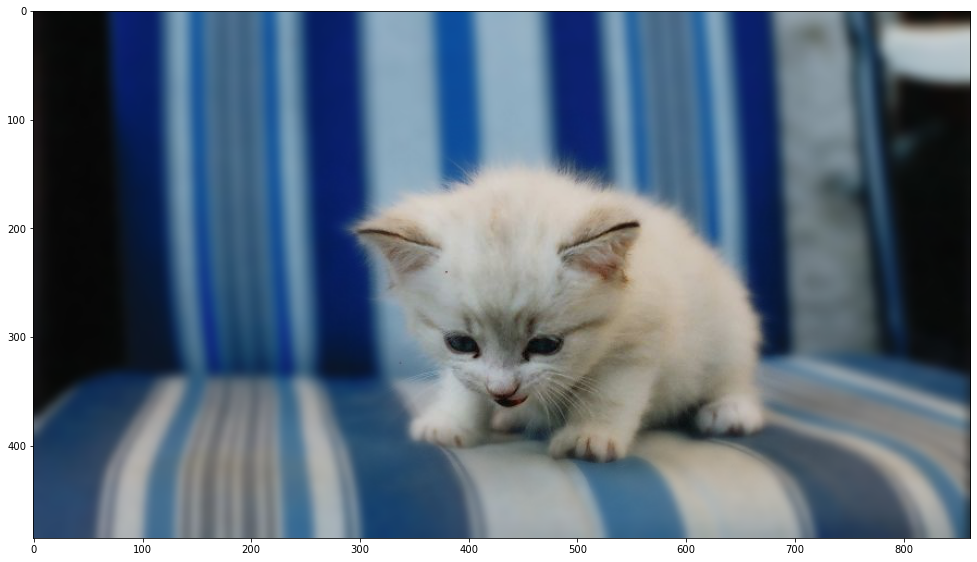

In [16]:
plt.figure(figsize=(17.24, 9.70))
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plt.show()

자연스럽습니다!

현재 사용한 DeepLab 모델의 Semantic Segmentation 성능을 높이려면 Google Brain의 Struct2Depth처럼 딥러닝을 활용해 깊이를 계산해 사용하는 방법이 제일 효과적이지 않을까 생각합니다.  
위에서 구현한 방법으로는 전체 심도를 표현하는 것이 불가능해 배경이 전반적으로 동일한 정도의 블러가 적용되지만, 깊이정보를 알 수 있으면 배경의 각 피사체 거리마다 다른 심도를 표현할 수도 있을 것입니다.  

혹은 주 측정된 피사체의 크기를 활용해 표현하고 싶은 심도를 그에 맞게 조절하여 마스킹하는 것도 방법이 될 수 있겠습니다. 애초에 카메라의 아웃포커싱이 피사체를 제외한 부분을 날리는 것이 아니라 초점과 심도에 따른 블러이기 때문에, 측정된 피사체의 크기에 따른 적정심도를 통해 블러효과를 조절하는 것도 좋은 방법입니다. 여기에 배경의 깊이정보까지 더해져 부분마다 적절한 블러효과가 들어가면 더욱 좋겠죠!

---

## 후기

최근 다른 일들 때문에 수업 참여를 제대로 하지 못해 마감 당일이 되어서야 겨우 시작할 수 있었는데, 이미지 문제를 찾아서 해결하라는 이야기에 앞길이 막막했습니다. 하지만 다행이 구글신이 도우셔서 눈에 보이는 문제는 해결할 수 있었습니다.  

제출에 급급해 코드를 하나하나 뜯어서 씹어먹지는 못 했지만, 그래도 실습을 통해 이러한 것도 할 수 있구나 체감할 수 있어서 좋았습니다. 그리고 마지막에 시맨틱 세그멘테이션 마스크의 오류를 해결하는 방법에 대해 조금이나마 생각해보는 것도 재미있었습니다. 이미 나와있는 기술들도 신기한 것들이 많아 기회가 되면 공부해보고 싶습니다.